In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import scipy.stats as stats
import random
import string

warnings.filterwarnings("ignore")

cluster = 'venus'
raw_data = pd.read_csv(f"./data/{cluster}/cluster_log.csv")
num_cpus = {'venus': 48, 'uranus': 64, 'earth': 48, 'saturn': 64}
raw_data.head()

,job_id,user,vc,gpu_num,cpu_num,node_num,state,submit_time,start_time,end_time,duration,queue
0,363167,u1Eem,vccJW,32,160,4,TIMEOUT,2020-03-18 04:01:39,2020-03-18 04:01:39,2020-04-01 04:01:54,1209615,0
1,394656,uBFjQ,vcefl,0,4,1,TIMEOUT,2020-03-25 11:08:58,2020-03-25 11:08:58,2020-04-08 11:09:06,1209608,0
2,394948,uhSlK,vcHvQ,8,1,1,FAILED,2020-03-25 17:00:06,2020-03-25 17:00:06,2020-04-04 12:40:45,848439,0
3,396689,uLoqx,vcEwI,4,16,1,COMPLETED,2020-03-26 13:42:30,2020-03-26 13:42:30,2020-04-02 21:36:47,633257,0
4,396912,uINUJ,vcHvQ,8,16,1,TIMEOUT,2020-03-26 17:38:08,2020-03-26 17:38:08,2020-04-09 17:38:14,1209606,0


In [61]:
# clean data
# data = raw_data[(raw_data['state'] == "COMPLETED") & (raw_data['duration'] > 60) & raw_data['gpu_num'] > 0]
# data = raw_data[((raw_data['state'] == "COMPLETED")) & (raw_data['gpu_num'] > 0)]
data = raw_data[(raw_data['gpu_num'] > 0)]
data['submit_time'] = pd.to_datetime(data["submit_time"])
data.sort_values(by="submit_time", inplace=True)
data = data[['job_id', 'user', 'gpu_num', 'cpu_num', 'state', 'submit_time', 'start_time', 'end_time', 'duration', 'queue']]
data.sort_values(by='duration')
data.head()

,job_id,user,gpu_num,cpu_num,state,submit_time,start_time,end_time,duration,queue
0,363167,u1Eem,32,160,TIMEOUT,2020-03-18 04:01:39,2020-03-18 04:01:39,2020-04-01 04:01:54,1209615,0
2,394948,uhSlK,8,1,FAILED,2020-03-25 17:00:06,2020-03-25 17:00:06,2020-04-04 12:40:45,848439,0
3,396689,uLoqx,4,16,COMPLETED,2020-03-26 13:42:30,2020-03-26 13:42:30,2020-04-02 21:36:47,633257,0
4,396912,uINUJ,8,16,TIMEOUT,2020-03-26 17:38:08,2020-03-26 17:38:08,2020-04-09 17:38:14,1209606,0
5,396913,uINUJ,8,16,TIMEOUT,2020-03-26 17:38:21,2020-03-26 17:38:21,2020-04-09 17:38:44,1209623,0


In [62]:
# data = data.iloc[:1000]

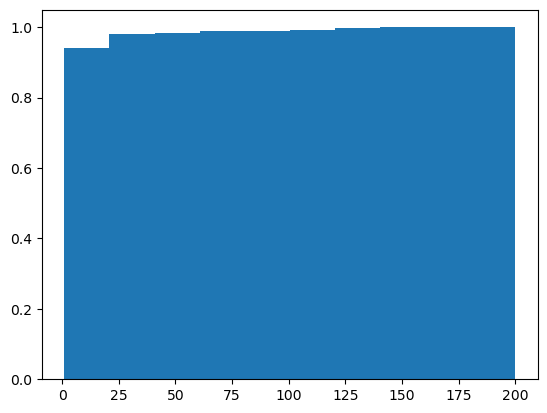

In [63]:
plt.hist(data['gpu_num'], cumulative=True, density=True)
plt.show()

In [64]:
"""
使用任务持续时间作为指数分布的λ参数是基于一种假设，即任务的持续时间与数据集大小之间存在某种关联。这个假设源自于一个观察，即在深度学习任务中，处理大的数据集通常需要更长的时间。

通过将任务持续时间映射为λ参数，我们实际上是在模拟一个概率分布，该分布描述了对于一个给定的任务持续时间，数据集的大小可能会有多大。由于指数分布是一种单调递减的分布，因此对于较长的任务持续时间，它倾向于生成较大的数据集大小，这符合我们的直觉和观察。

然而，这仍然是一个简化的假设，并不能完全捕捉到实际中任务持续时间与数据集大小之间可能存在的复杂关系。在实际的情况中，任务的持续时间可能受到很多其他因素的影响，比如任务的复杂性、硬件设施的性能、网络带宽等等。
"""

durations = []
for i, row in data.iterrows():
    if row['gpu_num'] == 0:
        durations.append(row['duration'] / row['cpu_num'])
    else:
        durations.append(row['duration'] / row['gpu_num'])

num_workers = data['gpu_num'].to_numpy()

# 对duration进行归一化处理
min_duration = np.min(durations)
max_duration = np.max(durations)
dataset_size_range = np.arange(10, 1010, 10)
simulated_size = []

for dur in durations:
    # 首先，我们需要将duration和dataset size都归一化到0-1的范围
    duration = (dur - min_duration) / (max_duration - min_duration)
    norm_dataset_size_range = (dataset_size_range - np.min(dataset_size_range)) / (np.max(dataset_size_range) - np.min(dataset_size_range))

    # 然后，我们使用归一化后的duration作为指数分布的λ参数
    lambda_param = duration

    # 生成对应的概率分布
    prob_distribution = np.exp(-lambda_param * norm_dataset_size_range)

    # 由于这个概率分布并不是一个概率密度函数，我们需要对其进行归一化
    prob_distribution = prob_distribution / np.sum(prob_distribution)

    # 最后，我们根据这个概率分布在dataset size范围内进行随机抽样，得到模拟的dataset size
    s = np.random.choice(norm_dataset_size_range, p=prob_distribution)
    
    simulated_size.append(s * ((np.max(dataset_size_range) - np.min(dataset_size_range))) + np.min(dataset_size_range))

datasources = []
for i, dataset_size in enumerate(simulated_size):
    chunks = []
    chunk_size = np.ceil(dataset_size / num_workers[i])
    if chunk_size == 0:
        dataset_size = chunk_size * num_workers[i]
    assert chunk_size > 0
    print(dataset_size, chunk_size)
    s = 0
    while s < dataset_size:
        chunks.append({
            'ETag': ''.join(random.choices(string.ascii_uppercase + string.digits, k=10)),
            'Size': chunk_size,
            'ChunkSize': chunk_size,
            'ExistOnSSD': False,
            'ExistOnHDD': False,
            'Location': None,
            'SourceLocation': None
        })
        s += chunk_size
    else:
        if s > dataset_size:
            chunks.append({
                'ETag': ''.join(random.choices(string.ascii_uppercase + string.digits, k=10)),
                'Size': dataset_size - s + chunk_size,
                'ChunkSize': dataset_size - s + chunk_size,
                'ExistOnSSD': False,
                'ExistOnHDD': False,
                'Location': None,
                'SourceLocation': None
            })

    datasources.append({
        'dataset_size': dataset_size,
        'chunks': chunks
    })

data['datasource'] = datasources

420.0 14.0
450.0 57.0
1000.0 250.0
920.0 115.0
450.0 57.0
240.0 60.0
200.0 9.0
220.0 14.0
180.0 90.0
620.0 39.0
690.0 44.0
240.0 15.0
170.0 170.0
580.0 73.0
680.0 85.0
800.0 100.0
860.0 108.0
540.0 17.0
700.0 175.0
440.0 55.0
330.0 165.0
740.0 47.0
800.0 34.0
980.0 123.0
840.0 210.0
210.0 14.0
810.0 203.0
230.0 58.0
60.0 8.0
880.0 110.0
490.0 245.0
100.0 13.0
520.0 65.0
860.0 108.0
130.0 17.0
510.00000000000006 16.0
850.0 18.0
500.0 9.0
140.0 35.0
230.0 230.0
900.0 57.0
540.0 17.0
430.0 430.0
190.0 190.0
630.0 315.0
640.0 640.0
910.0 910.0
630.0 630.0
150.0 19.0
190.0 24.0
930.0 117.0
970.0 243.0
210.0 53.0
700.0 44.0
320.0 20.0
310.0 20.0
870.0 109.0
760.0 95.0
310.0 310.0
870.0 870.0
10.0 10.0
750.0 750.0
500.0 63.0
40.0 5.0
940.0 118.0
240.0 15.0
970.0 61.0
610.0 39.0
880.0 55.0
130.0 9.0
860.0 54.0
450.0 90.0
150.0 150.0
90.0 23.0
420.0 70.0
160.0 20.0
900.0 225.0
510.00000000000006 128.0
920.0 58.0
330.0 21.0
630.0 40.0
550.0 69.0
970.0 970.0
990.0 495.0
680.0 680.0
230.0 15.0
800

In [65]:
# 计算行之间的时间差和用户ID是否相同
data['time_difference'] = data['submit_time'].diff().dt.total_seconds().fillna(0)
data['same_user'] = data['user'].eq(data['user'].shift())

# 根据时间差和用户ID来确定merge_group
data['merge_group'] = ((data['time_difference'] > 300) | ~data['same_user']).cumsum()

# 合并属于同一组的行
merged_df = data.groupby('merge_group')

workloads = []
for gid, df in merged_df:
    df.reset_index(inplace=True, drop=True)
    start_time = df.sort_values(by='start_time').iloc[0]['start_time']
    end_time = df.sort_values(by='end_time').iloc[-1]['end_time']
    deploy = {
        'deploy_id': ''.join(random.choices(string.ascii_uppercase + string.digits, k=7)),
        'user': df.iloc[0]['user'],
        'submit_time': df['submit_time'][0].strftime("%Y-%m-%d %H:%M:%S"),
        'datasource': df['datasource'][0]
    }
    jobs = []
    
    for i, row in df.iterrows():
        job = {
            'job_id': ''.join(random.choices(string.ascii_uppercase + string.digits, k=7)),
            'cpu': int(min(row['cpu_num'] / row['gpu_num'], num_cpus[cluster])),  # CPU can't exceed the # cores on a node, because GPU can't be divided
            'gpu': 1,
            'numWorkers': row['gpu_num'],
            'storage': deploy['datasource']['dataset_size'],
            'start_time': row['start_time'],
            'end_time': row['end_time'],
            'queue': row['queue'],
            'duration': row['duration'],
            'location': []
        }
        jobs.append(job)
    deploy['jobs'] = jobs
    workloads.append(deploy)

with open(f'./experiments/{cluster}/{cluster}.json', 'w') as f:
    json.dump(workloads, f, indent=4)

In [4]:
rlt = []
clusters = ['earth', 'saturn', 'uranus', 'venus']
for clt in clusters:
    with open(f'./experiments/{clt}/{clt}.json', 'r') as f:
        workloads = json.load(f)
        t1, t2, t3, t4 = 0, 0, 0, 0
        for w in workloads:
            if len(w['jobs']) == 1:
                t1 += 1
            else:
                t2 += 1
            
            for job in w['jobs']:
                if job['numWorkers'] > 1:
                    t3 += 1
                else:
                    t4 += 1

        rlt.append([t1, t2, t3, t4])

rlt = pd.DataFrame(rlt, columns=['single-job', 'multi-job', 'dist', 'non-dist'], index=clusters)

In [6]:
rlt.to_csv('sta.csv')